In [ ]:
"""
FEATURE MAP VISUALIZATOR

can we see what a layer see? 

part of the neural style transfer project | see Fig 1 of the paper
"""
import torch
import torch.nn as nn
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0

from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
# Useful functions for image manipulation 

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_image(img_path):
    image = Image.open(img_path).convert('RGB')
    print(type(image))
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std= [0.229, 0.224, 0.225])
    ])
    return img_transform(image).unsqueeze(0)

# Function to convert a tensor back to an image
def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    # Un-normalize the image
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    # Clip the pixel values to be between 0 and 1
    image = image.clip(0, 1)
    return image

In [ ]:
# Fetch image and convert it to a torch tensor

file_dir = '/home/rotakagui/projects/pytorch-neural-style-transfer'
content_img_path = os.path.join(file_dir, 'data', 'content', 'bariloche.jpg')
img = load_image(content_img_path).to(DEVICE)

<class 'PIL.Image.Image'>


In [ ]:
# Definition of the Vgg19 model and extraction of feature map we want to see 

vgg_net = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True);
vgg_net.eval().to(DEVICE)
model = create_feature_extractor(vgg_net,{'features.33':'conv5'})

Using cache found in /home/rotakagui/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rotakagui/miniconda3/envs/jupy/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rotakagui/miniconda3/envs/jupy/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# get the feature map of a particular layer given a content image and definition of white noise

with torch.no_grad():
    fixed_out = model(img)['conv5'].detach() # for now we select conv5, but it can be any of the other layer
white_noise = torch.rand(size=img.shape, requires_grad=True, device=DEVICE)

loss function = 0.000238: 100%|██████████| 1000/1000 [00:31<00:00, 31.47it/s]


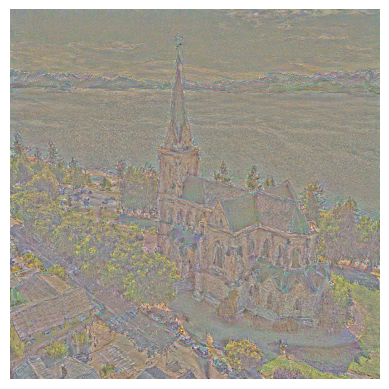

In [ ]:
# Optimization loop

epochs = 1000
optimizer = torch.optim.Adam([white_noise],lr=0.003)

for i in (t := trange(epochs)):
    
    # At each epoch, we send through our newly `white_noise` image
    loss = torch.mean((model(white_noise)['conv5'] - fixed_out)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    t.set_description(f'loss function = {loss:.6f}')
    
    # if i % 50 == 0:
    #     reconstructed_image = im_convert(white_noise)
    #     image = Image.fromarray((reconstructed_image * 255).astype('uint8'))
    #     image.save('output_image.jpg')

reconstructed_image = im_convert(white_noise)
reconstructed_image = Image.fromarray((reconstructed_image * 255).astype('uint8'))    
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()